Hypothesis Tests

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [26]:
irCitiesDf = pd.read_csv(r"C:\Users\Taha\Desktop\Folder\QBTC-Divar-Project\Datas\iran_city_classification.csv")

citiesLe = LabelEncoder()
irCitiesDf = irCitiesDf.rename(columns={
    'دسته‌بندی' : 'city_type',
    'نام شهر' : 'city_name'
})
irCitiesDf["city_type"] = citiesLe.fit_transform(irCitiesDf["city_type"])

In [27]:
mainDf = pd.read_csv(r"C:\Users\Taha\Desktop\Folder\QBTC-Divar-Project\Datas\Divar.csv")

C:\Users\Taha\AppData\Local\Temp\ipykernel_13744\3759486485.py:1: DtypeWarning: Columns (11,27,29,53) have mixed types. Specify dtype option on import or set low_memory=False.
  mainDf = pd.read_csv(r"C:\Users\Taha\Desktop\Folder\QBTC-Divar-Project\Datas\Divar.csv")


In [28]:
mainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 61 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1000000 non-null  int64  
 1   cat2_slug                   1000000 non-null  object 
 2   cat3_slug                   999999 non-null   object 
 3   city_slug                   999998 non-null   object 
 4   neighborhood_slug           437139 non-null   object 
 5   created_at_month            1000000 non-null  object 
 6   user_type                   288882 non-null   object 
 7   description                 1000000 non-null  object 
 8   title                       999946 non-null   object 
 9   rent_mode                   352994 non-null   object 
 10  rent_value                  351322 non-null   float64
 11  rent_to_single              19 non-null       object 
 12  rent_type                   103961 non-null   object 
 13

In [29]:

big_cities_name = []
for j in irCitiesDf[irCitiesDf['city_type']== 1]['city_name'].values:
    big_cities_name.append(j)

mainDf['big_city'] = mainDf['city_slug'].isin(big_cities_name).astype(int)
mainDf['created_at_month'] = pd.to_datetime(mainDf['created_at_month'])

The First Hypothesis

In [30]:
mainDf.describe()["building_size"]

count    9.803940e+05
mean     4.440648e+03
min      1.000000e+00
25%      7.500000e+01
50%      1.030000e+02
75%      1.650000e+02
max      1.000000e+07
std      1.367118e+05
Name: building_size, dtype: float64

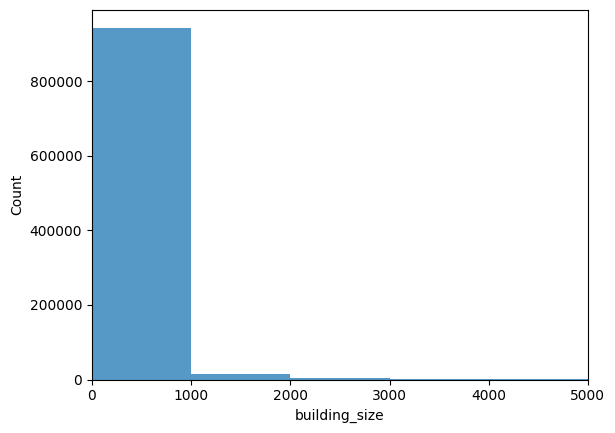

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(mainDf["building_size"], bins=10000)
plt.xlim(0, 5000)
plt.show()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

low, high = mainDf["building_size"].quantile([0.01, 0.99])
mainDf_filtered = mainDf[(mainDf["building_size"] >= low) & (mainDf["building_size"] <= high)]

mainDf_filtered.describe()["building_size"] 

Q1 = mainDf_filtered["building_size"].quantile(0.25)
Q3 = mainDf_filtered["building_size"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mainDf_filtered = mainDf_filtered[
    (mainDf_filtered["building_size"] >= lower_bound) &
    (mainDf_filtered["building_size"] <= upper_bound)
]

cleanedDf = mainDf_filtered.copy()
cleanedDf = mainDf_filtered.drop_duplicates()

In [33]:
cleanedDf.describe()["building_size"]

count    854786.000000
mean        108.595018
min          12.000000
25%          70.000000
50%          99.000000
75%         135.000000
max         290.000000
std          54.560541
Name: building_size, dtype: float64

In [34]:
cleanedDf = cleanedDf.drop(["Unnamed: 0"] , axis=1)
cleanedDf = cleanedDf[~cleanedDf["cat3_slug"].isna()]
cleanedDf = cleanedDf[~cleanedDf["city_slug"].isna()]

cleanedDf = pd.merge(
    cleanedDf,
    irCitiesDf,
    left_on='city_slug',
    right_on='city_name',
    how='left'
)

In [35]:
cleanedDf["cat3_slug"].unique()

array(['apartment-sell', 'apartment-rent', 'office-rent', 'shop-sell',
       'house-villa-sell', 'house-villa-rent', 'plot-old', 'shop-rent',
       'office-sell', 'industry-agriculture-business-sell', 'villa',
       'suite-apartment', 'industry-agriculture-business-rent',
       'workspace', 'presell', 'partnership'], dtype=object)

In [36]:
cleanedDf[cleanedDf["cat3_slug"] == "house-villa-sell"]["title"].head()

16                                       ویلای خوش نقشه
19    ویلا باغ۶۰۰م سنددار شهرکی ٪زیر قیمت٪مشجر جاده ...
20                 فروش خانه دو طبقه کمربندی غربی توحید
28      ویلا دوبلکس باغی فول مبله جنگلی/سند فر.وش فو.ری
35                             فروش مهندسی ساز شرف اباد
Name: title, dtype: object

Using Mannwhitneyu because it is Anti-Outlier and good for not normal datas like here

In [37]:
from scipy.stats import mannwhitneyu

residential_categories = [
    "apartment-sell",
    "apartment-rent",
    "suite-apartment",
]

residentialDf = cleanedDf[cleanedDf["cat3_slug"].isin(residential_categories)].copy()

megacity = residentialDf[residentialDf["big_city"] == 1]["building_size"]
smalltown = residentialDf[residentialDf["big_city"] == 0]["building_size"]

t_stat, p_val = mannwhitneyu(megacity, smalltown,alternative='two-sided')
if p_val<=0.5:
    print('This is a True Hypothesis')
else:
    print('False')

This is a True Hypothesis


The Second Hypothesis

In [38]:
cleanedDf["construction_year"].unique()

array(['۱۳۸۴', '۱۴۰۱', '۱۴۰۰', '۱۴۰۳', '۱۳۸۹', '۱۳۹۵', '۱۳۹۳', '۱۳۹۶',
       '۱۳۸۷', '۱۳۸۵', '۱۳۹۰', '۱۳۹۸', '۱۴۰۲', '۱۳۸۸', 'قبل از ۱۳۷۰',
       '۱۳۹۲', '۱۳۸۳', '۱۳۹۴', '۱۳۹۱', '۱۳۸۰', nan, '۱۳۷۸', '۱۳۷۵',
       '۱۳۹۹', '۱۳۸۲', '۱۳۹۷', '۱۳۸۶', '۱۳۷۹', '۱۳۷۲', '۱۳۷۴', '۱۳۷۶',
       '۱۳۷۷', '۱۳۷۱', '۱۳۸۱', '۱۳۷۳'], dtype=object)

In [39]:
def numbers_persian_to_english(persian_number):
    persian_numbers = '۰۱۲۳۴۵۶۷۸۹'
    english_numbers = '0123456789'

    transform = str.maketrans(persian_numbers, english_numbers)

    return str(persian_number).translate(transform)

In [40]:
cleanedDf['construction_year'] = cleanedDf['construction_year'].str.replace('قبل از ۱۳۷۰', '۱۳۶۹', regex=False)
cleanedDf['construction_year'] = cleanedDf['construction_year'].apply(numbers_persian_to_english)

cleanedDf = cleanedDf[cleanedDf['construction_year'].notna()] 
cleanedDf = cleanedDf[cleanedDf['construction_year'].str.isnumeric()] 

cleanedDf['construction_year'] = cleanedDf['construction_year'].astype(int)
cleanedDf['is_old'] = cleanedDf['construction_year'].apply(lambda x: 1 if x < 1396 else 0)


In [42]:
old_houses = cleanedDf[cleanedDf['is_old'] == 0]['building_size']
new_houses = cleanedDf[cleanedDf['is_old'] == 1]['building_size']

print("Old Houses Mean:", old_houses.mean())
print("New Houses Mean:", new_houses.mean())

t_stat, p_val = mannwhitneyu(old_houses, new_houses, alternative='two-sided')
if p_val<=0.5:
    print('This Hypothesis is True')
else:
    print('False')


Old Houses Mean: 110.75866465036019
New Houses Mean: 94.0418206364513
This Hypothesis is True


The Third Hypothesis

In [43]:
has_business_deed_true = cleanedDf['description'].str.contains(r'\bسند تجاری\b', regex=True, na=False) & (cleanedDf['has_business_deed'].isnull())
cleanedDf.loc[has_business_deed_true, 'has_business_deed'] = True

In [44]:

commercial_types = ['shop-sell', 'office-sell', 'industry-agriculture-business-sell']
commercial_df = cleanedDf[cleanedDf['cat3_slug'].isin(commercial_types)]
commercial_df = commercial_df.dropna(subset=['price_value', 'has_business_deed'])

with_deed = commercial_df[commercial_df['has_business_deed'] == 1]['price_value']
without_deed = commercial_df[commercial_df['has_business_deed'] == 0]['price_value']

print("With Deed Mean Price:", with_deed.mean())
print("Without Deed Mean Price:", without_deed.mean())


t_stat, p_val = mannwhitneyu(with_deed, without_deed,alternative='two-sided' )
if p_val<=0.5:
    print('This Hypothesis is True')
else:
    print('False')

With Deed Mean Price: 27772282593.82166
Without Deed Mean Price: 24174463163.682148
This Hypothesis is True


The forth Hypothesis

In [45]:
df = cleanedDf.copy()

df = df[df['price_value'].notna()]
sauna_true = df['description'].str.contains(r'\bسونا\b', regex=True, na=False) & (df['has_sauna'].isnull())
df.loc[sauna_true, 'has_sauna'] = True

jacuzzi_true = df['description'].str.contains(r'\bجکوزی\b', regex=True, na=False) & (df['has_jacuzzi'].isnull())
df.loc[jacuzzi_true, 'has_jacuzzi'] = True

pool_true = df['description'].str.contains(r'\bاستخر\b', regex=True, na=False) & (df['has_pool'].isnull())
df.loc[pool_true, 'has_pool'] = True

barbecue_true = df['description'].str.contains(r'\bباربیکیو\b', regex=True, na=False) & (df['has_barbecue'].isnull())
df.loc[barbecue_true, 'has_barbecue'] = True

security_guard_true = ((df['description'].str.contains(r'\bنگهبان\b', regex=True, na=False)) | (df['description'].str.contains(r'\bنگهبانی\b', regex=True, na=False)) | (df['description'].str.contains(r'\bلابی من\b', regex=True, na=False))) & (df['has_security_guard'].isnull())
df.loc[security_guard_true, 'has_security_guard'] = True

def fill_null(df, columns_name, value):
    for i in columns_name:
        df[i].fillna(value, inplace = True)

columns_False = ['has_sauna','has_jacuzzi','has_pool','has_barbecue',
                 'has_security_guard','has_business_deed',
                 'has_balcony','has_elevator','is_rebuilt',
                 'has_parking','has_warehouse','has_gas',
                 'has_electricity', 'has_water']
fill_null(df, columns_False, False)

df['luxury'] = df[['has_sauna', 'has_jacuzzi', 'has_pool', 'has_security_guard', 'has_barbecue']].sum(axis=1)


C:\Users\Taha\AppData\Local\Temp\ipykernel_13744\2630484847.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i].fillna(value, inplace = True)


In [46]:
df.shape

(426785, 65)

In [48]:


with_luxury = df[df["luxury"] == 1]["price_value"]
without_luxury = df[df["luxury"] == 0]["price_value"]

t_stat, p_val = mannwhitneyu(with_luxury, without_luxury, alternative='two-sided')

print("With Luxury Mean Price:", with_luxury.mean())
print("Without Luxury Mean Price:", without_luxury.mean())
if p_val<=0.5:
    print('This Hypothesis is True')
else:
    print('False')

With Luxury Mean Price: 14759986137.269218
Without Luxury Mean Price: 13736755134.187271
This Hypothesis is True
